In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tempfile import TemporaryDirectory
import time
from tqdm import tqdm

import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.backends.cudnn as cudnn

import torchvision
from torchvision.models import resnet101, resnet50, resnet18
import torchvision.transforms as transforms
import torchvision.transforms as tt
from torchvision.datasets import CIFAR100 
from torchvision import datasets, models, transforms
from torchinfo import summary

In [2]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [3]:
os.makedirs('/kaggle/working/models')

In [ ]:
!rm -rf /kaggle/working/*

#### Code to translate from fine labels into coarse labels number used by models

In [43]:
klasa_superklasa_num={}
for id_klasy, liczba_klasy in classes_indexing.items():
    if id_klasy in filt_class_map:
        superklasa= filt_class_map[id_klasy]
        if superklasa in coarse_classes_indexing:
            liczba_superklasy=coarse_classes_indexing[superklasa]
            klasa_superklasa_num[liczba_klasy]=liczba_superklasy

In [4]:
fine_to_coarse={0: 21, 1: 39, 2: 23, 3: 23, 4: 14, 5: 40, 6: 46, 7: 1, 8: 1, 9: 1, 10: 6, 11: 4, 12: 32, 13: 21, 14: 13, 15: 33, 16: 33, 17: 33, 18: 15, 19: 15, 20: 4, 21: 4, 22: 4, 23: 31, 24: 17, 25: 17, 26: 17, 27: 17, 28: 17, 29: 17, 30: 9, 31: 9,
                      32: 9, 33: 51, 34: 51, 35: 3, 36: 6, 37: 6, 38: 6, 39: 6, 40: 6, 41: 6, 42: 6, 43: 6, 44: 8, 45: 8, 46: 18, 47: 38, 48: 28, 49: 47, 50: 47, 51: 47, 52: 47, 53: 47, 54: 37, 55: 37, 56: 37, 57: 47, 58: 3, 59: 42, 60: 10, 61: 26, 62: 10,
                      63: 0, 64: 26, 65: 7, 66: 7, 67: 11, 68: 2, 69: 26, 70: 49, 71: 7, 72: 30, 73: 22, 74: 10, 75: 43, 76: 34, 77: 0, 78: 16, 79: 43, 80: 43, 81: 45, 82: 7, 83: 43, 84: 50, 85: 10, 86: 42, 87: 19, 88: 43, 89: 11, 90: 16, 91: 7, 92: 19, 93: 7,
                      94: 49, 95: 49, 96: 34, 97: 26, 98: 26, 99: 29, 100: 43, 101: 34, 102: 34, 103: 45, 104: 12, 105: 10, 106: 0, 107: 49, 108: 5, 109: 42, 110: 19, 111: 49, 112: 10, 113: 16, 114: 49, 115: 5, 116: 49, 117: 43, 118: 34, 119: 10, 120: 10, 121: 49,
                      122: 43, 123: 0, 124: 7, 125: 29, 126: 29, 127: 19, 128: 19, 129: 20, 130: 11, 131: 43, 132: 41, 133: 49, 134: 10, 135: 22, 136: 43, 137: 50, 138: 41, 139: 42, 140: 26, 141: 19, 142: 26, 143: 2, 144: 10, 145: 49, 146: 41, 147: 42, 148: 41,
                      149: 10, 150: 27, 151: 19, 152: 34, 153: 49, 154: 34, 155: 19, 156: 10, 157: 34, 158: 10, 159: 43, 160: 12, 161: 44, 162: 7, 163: 43, 164: 49, 165: 34, 166: 49, 167: 42, 168: 0, 169: 10, 170: 34, 171: 2, 172: 11, 173: 34, 174: 12, 175: 12,
                      176: 35, 177: 12, 178: 22, 179: 22, 180: 22, 181: 22, 182: 22, 183: 48, 184: 48, 185: 25, 186: 24, 187: 24, 188: 24, 189: 24, 190: 22, 191: 22, 192: 22, 193: 22, 194: 34, 195: 34, 196: 13, 197: 34, 198: 34, 199: 36}

## For doublecriterion loss
To cahnge targets and labels from fine labels into coarse labels

In [5]:
def get_superclass(targets):
    fine_to_coarse={0: 21, 1: 39, 2: 23, 3: 23, 4: 14, 5: 40, 6: 46, 7: 1, 8: 1, 9: 1, 10: 6, 11: 4, 12: 32, 13: 21, 14: 13, 15: 33, 16: 33, 17: 33, 18: 15, 19: 15, 20: 4, 21: 4, 22: 4, 23: 31, 24: 17, 25: 17, 26: 17, 27: 17, 28: 17, 29: 17, 30: 9, 31: 9,
                      32: 9, 33: 51, 34: 51, 35: 3, 36: 6, 37: 6, 38: 6, 39: 6, 40: 6, 41: 6, 42: 6, 43: 6, 44: 8, 45: 8, 46: 18, 47: 38, 48: 28, 49: 47, 50: 47, 51: 47, 52: 47, 53: 47, 54: 37, 55: 37, 56: 37, 57: 47, 58: 3, 59: 42, 60: 10, 61: 26, 62: 10,
                      63: 0, 64: 26, 65: 7, 66: 7, 67: 11, 68: 2, 69: 26, 70: 49, 71: 7, 72: 30, 73: 22, 74: 10, 75: 43, 76: 34, 77: 0, 78: 16, 79: 43, 80: 43, 81: 45, 82: 7, 83: 43, 84: 50, 85: 10, 86: 42, 87: 19, 88: 43, 89: 11, 90: 16, 91: 7, 92: 19, 93: 7,
                      94: 49, 95: 49, 96: 34, 97: 26, 98: 26, 99: 29, 100: 43, 101: 34, 102: 34, 103: 45, 104: 12, 105: 10, 106: 0, 107: 49, 108: 5, 109: 42, 110: 19, 111: 49, 112: 10, 113: 16, 114: 49, 115: 5, 116: 49, 117: 43, 118: 34, 119: 10, 120: 10, 121: 49,
                      122: 43, 123: 0, 124: 7, 125: 29, 126: 29, 127: 19, 128: 19, 129: 20, 130: 11, 131: 43, 132: 41, 133: 49, 134: 10, 135: 22, 136: 43, 137: 50, 138: 41, 139: 42, 140: 26, 141: 19, 142: 26, 143: 2, 144: 10, 145: 49, 146: 41, 147: 42, 148: 41,
                      149: 10, 150: 27, 151: 19, 152: 34, 153: 49, 154: 34, 155: 19, 156: 10, 157: 34, 158: 10, 159: 43, 160: 12, 161: 44, 162: 7, 163: 43, 164: 49, 165: 34, 166: 49, 167: 42, 168: 0, 169: 10, 170: 34, 171: 2, 172: 11, 173: 34, 174: 12, 175: 12,
                      176: 35, 177: 12, 178: 22, 179: 22, 180: 22, 181: 22, 182: 22, 183: 48, 184: 48, 185: 25, 186: 24, 187: 24, 188: 24, 189: 24, 190: 22, 191: 22, 192: 22, 193: 22, 194: 34, 195: 34, 196: 13, 197: 34, 198: 34, 199: 36}
    targets_cpu=targets.cpu().numpy()
    supertargets=[fine_to_coarse[target] for target in targets_cpu]
    supertargets=torch.tensor(supertargets, dtype=torch.int64, device=targets.device)
    return supertargets

In [6]:
def get_superclass_logits(outputs, fine_to_coarse):
    num_superclasses = len(set(fine_to_coarse.values())) # 20 superclass
    superclass_logits = torch.zeros((outputs.size(0), num_superclasses)).to(outputs.device)
    for fine_class, coarse_class in fine_to_coarse.items():
        superclass_logits[:, coarse_class] += outputs[:, fine_class] 
    return superclass_logits

# Tiny Imagenet dataset - 200 classes

# Validation set

In [7]:
classes_indexing={'n01443537': 0, 'n01629819': 1, 'n01641577': 2, 'n01644900': 3, 'n01698640': 4, 'n01742172': 5, 'n01768244': 6, 'n01770393': 7, 'n01774384': 8,
                  'n01774750': 9, 'n01784675': 10, 'n01855672': 11, 'n01882714': 12, 'n01910747': 13, 'n01917289': 14, 'n01944390': 15, 'n01945685': 16, 'n01950731': 17,
                  'n01983481': 18, 'n01984695': 19, 'n02002724': 20, 'n02056570': 21, 'n02058221': 22, 'n02074367': 23, 'n02085620': 24, 'n02094433': 25, 'n02099601': 26,
                  'n02099712': 27, 'n02106662': 28, 'n02113799': 29, 'n02123045': 30, 'n02123394': 31, 'n02124075': 32, 'n02125311': 33, 'n02129165': 34, 'n02132136': 35,
                  'n02165456': 36, 'n02190166': 37, 'n02206856': 38, 'n02226429': 39, 'n02231487': 40, 'n02233338': 41, 'n02236044': 42, 'n02268443': 43, 'n02279972': 44,
                  'n02281406': 45, 'n02321529': 46, 'n02364673': 47, 'n02395406': 48, 'n02403003': 49, 'n02410509': 50, 'n02415577': 51, 'n02423022': 52, 'n02437312': 53,
                  'n02480495': 54, 'n02481823': 55, 'n02486410': 56, 'n02504458': 57, 'n02509815': 58, 'n02666196': 59, 'n02669723': 60, 'n02699494': 61, 'n02730930': 62,
                  'n02769748': 63, 'n02788148': 64, 'n02791270': 65, 'n02793495': 66, 'n02795169': 67, 'n02802426': 68, 'n02808440': 69, 'n02814533': 70, 'n02814860': 71,
                  'n02815834': 72, 'n02823428': 73, 'n02837789': 74, 'n02841315': 75, 'n02843684': 76, 'n02883205': 77, 'n02892201': 78, 'n02906734': 79, 'n02909870': 80,
                  'n02917067': 81, 'n02927161': 82, 'n02948072': 83, 'n02950826': 84, 'n02963159': 85, 'n02977058': 86, 'n02988304': 87, 'n02999410': 88, 'n03014705': 89,
                  'n03026506': 90, 'n03042490': 91, 'n03085013': 92, 'n03089624': 93, 'n03100240': 94, 'n03126707': 95, 'n03160309': 96, 'n03179701': 97, 'n03201208': 98,
                  'n03250847': 99, 'n03255030': 100, 'n03355925': 101, 'n03388043': 102, 'n03393912': 103, 'n03400231': 104, 'n03404251': 105, 'n03424325': 106,
                  'n03444034': 107, 'n03447447': 108, 'n03544143': 109, 'n03584254': 110, 'n03599486': 111, 'n03617480': 112, 'n03637318': 113, 'n03649909': 114, 
                  'n03662601': 115, 'n03670208': 116, 'n03706229': 117, 'n03733131': 118, 'n03763968': 119, 'n03770439': 120, 'n03796401': 121, 'n03804744': 122,
                  'n03814639': 123, 'n03837869': 124, 'n03838899': 125, 'n03854065': 126, 'n03891332': 127, 'n03902125': 128, 'n03930313': 129, 'n03937543': 130,
                  'n03970156': 131, 'n03976657': 132, 'n03977966': 133, 'n03980874': 134, 'n03983396': 135, 'n03992509': 136, 'n04008634': 137, 'n04023962': 138, 
                  'n04067472': 139, 'n04070727': 140, 'n04074963': 141, 'n04099969': 142, 'n04118538': 143, 'n04133789': 144, 'n04146614': 145, 'n04149813': 146,
                  'n04179913': 147, 'n04251144': 148, 'n04254777': 149, 'n04259630': 150, 'n04265275': 151, 'n04275548': 152, 'n04285008': 153, 'n04311004': 154,
                  'n04328186': 155, 'n04356056': 156, 'n04366367': 157, 'n04371430': 158, 'n04376876': 159, 'n04398044': 160, 'n04399382': 161, 'n04417672': 162,
                  'n04456115': 163, 'n04465501': 164, 'n04486054': 165, 'n04487081': 166, 'n04501370': 167, 'n04507155': 168, 'n04532106': 169, 'n04532670': 170,
                  'n04540053': 171, 'n04560804': 172, 'n04562935': 173, 'n04596742': 174, 'n04597913': 175, 'n06596364': 176, 'n07579787': 177, 'n07583066': 178,
                  'n07614500': 179, 'n07615774': 180, 'n07695742': 181, 'n07711569': 182, 'n07715103': 183, 'n07720875': 184, 'n07734744': 185, 'n07747607': 186,
                  'n07749582': 187, 'n07753592': 188, 'n07768694': 189, 'n07871810': 190, 'n07873807': 191, 'n07875152': 192, 'n07920052': 193, 'n09193705': 194,
                  'n09246464': 195, 'n09256479': 196, 'n09332890': 197, 'n09428293': 198, 'n12267677': 199}

In [8]:
classes_indexing_inverted={0: 'n01443537', 1: 'n01629819', 2: 'n01641577', 3: 'n01644900', 4: 'n01698640', 5: 'n01742172', 6: 'n01768244', 7: 'n01770393', 8: 'n01774384', 9: 'n01774750',
                           10: 'n01784675', 11: 'n01855672', 12: 'n01882714', 13: 'n01910747', 14: 'n01917289', 15: 'n01944390', 16: 'n01945685', 17: 'n01950731', 18: 'n01983481', 19: 'n01984695',
                           20: 'n02002724', 21: 'n02056570', 22: 'n02058221', 23: 'n02074367', 24: 'n02085620', 25: 'n02094433', 26: 'n02099601', 27: 'n02099712', 28: 'n02106662', 29: 'n02113799',
                           30: 'n02123045', 31: 'n02123394', 32: 'n02124075', 33: 'n02125311', 34: 'n02129165', 35: 'n02132136', 36: 'n02165456', 37: 'n02190166', 38: 'n02206856', 39: 'n02226429',
                           40: 'n02231487', 41: 'n02233338', 42: 'n02236044', 43: 'n02268443', 44: 'n02279972', 45: 'n02281406', 46: 'n02321529', 47: 'n02364673', 48: 'n02395406', 49: 'n02403003',
                           50: 'n02410509', 51: 'n02415577', 52: 'n02423022', 53: 'n02437312', 54: 'n02480495', 55: 'n02481823', 56: 'n02486410', 57: 'n02504458', 58: 'n02509815', 59: 'n02666196',
                           60: 'n02669723', 61: 'n02699494', 62: 'n02730930', 63: 'n02769748', 64: 'n02788148', 65: 'n02791270', 66: 'n02793495', 67: 'n02795169', 68: 'n02802426', 69: 'n02808440',
                           70: 'n02814533', 71: 'n02814860', 72: 'n02815834', 73: 'n02823428', 74: 'n02837789', 75: 'n02841315', 76: 'n02843684', 77: 'n02883205', 78: 'n02892201', 79: 'n02906734',
                           80: 'n02909870', 81: 'n02917067', 82: 'n02927161', 83: 'n02948072', 84: 'n02950826', 85: 'n02963159', 86: 'n02977058', 87: 'n02988304', 88: 'n02999410', 89: 'n03014705',
                           90: 'n03026506', 91: 'n03042490', 92: 'n03085013', 93: 'n03089624', 94: 'n03100240', 95: 'n03126707', 96: 'n03160309', 97: 'n03179701', 98: 'n03201208', 99: 'n03250847',
                           100: 'n03255030', 101: 'n03355925', 102: 'n03388043', 103: 'n03393912', 104: 'n03400231', 105: 'n03404251', 106: 'n03424325', 107: 'n03444034', 108: 'n03447447', 109: 'n03544143',
                           110: 'n03584254', 111: 'n03599486', 112: 'n03617480', 113: 'n03637318', 114: 'n03649909', 115: 'n03662601', 116: 'n03670208', 117: 'n03706229', 118: 'n03733131', 119: 'n03763968',
                           120: 'n03770439', 121: 'n03796401', 122: 'n03804744', 123: 'n03814639', 124: 'n03837869', 125: 'n03838899', 126: 'n03854065', 127: 'n03891332', 128: 'n03902125', 129: 'n03930313',
                           130: 'n03937543', 131: 'n03970156', 132: 'n03976657', 133: 'n03977966', 134: 'n03980874', 135: 'n03983396', 136: 'n03992509', 137: 'n04008634', 138: 'n04023962', 139: 'n04067472',
                           140: 'n04070727', 141: 'n04074963', 142: 'n04099969', 143: 'n04118538', 144: 'n04133789', 145: 'n04146614', 146: 'n04149813', 147: 'n04179913', 148: 'n04251144', 149: 'n04254777',
                           150: 'n04259630', 151: 'n04265275', 152: 'n04275548', 153: 'n04285008', 154: 'n04311004', 155: 'n04328186', 156: 'n04356056', 157: 'n04366367', 158: 'n04371430', 159: 'n04376876',
                           160: 'n04398044', 161: 'n04399382', 162: 'n04417672', 163: 'n04456115', 164: 'n04465501', 165: 'n04486054', 166: 'n04487081', 167: 'n04501370', 168: 'n04507155', 169: 'n04532106',
                           170: 'n04532670', 171: 'n04540053', 172: 'n04560804', 173: 'n04562935', 174: 'n04596742', 175: 'n04597913', 176: 'n06596364', 177: 'n07579787', 178: 'n07583066', 179: 'n07614500',
                           180: 'n07615774', 181: 'n07695742', 182: 'n07711569', 183: 'n07715103', 184: 'n07720875', 185: 'n07734744', 186: 'n07747607', 187: 'n07749582', 188: 'n07753592', 189: 'n07768694',
                           190: 'n07871810', 191: 'n07873807', 192: 'n07875152', 193: 'n07920052', 194: 'n09193705', 195: 'n09246464', 196: 'n09256479', 197: 'n09332890', 198: 'n09428293', 199: 'n12267677'}

In [9]:
annotations_filepath='/kaggle/input/tiny-imagenet/tiny-imagenet-200/val/val_annotations.txt'
annotations=pd.read_csv(annotations_filepath,sep='\t', header=None)
images_filepath='/kaggle/input/tiny-imagenet/tiny-imagenet-200/val/images/'

In [10]:
def load_val(annotations, im_directory):
    images=[]
    labels=[]
    for i, row in annotations.iterrows():
        image_name, label = row[0], row[1]
        image_path=os.path.join(im_directory,image_name)
        image=Image.open(image_path)
        if image.mode=='RGB':
            image_np=np.array(image) 
            #image_np=image_np.transpose(2,0,1)
            images.append(image_np)
            labels.append(label)
        
    return images, labels

class ValDataset(Dataset):
    def __init__(self, images, labels, label_idx_dict, transform=None):
        self.images=images
        self.labels=labels
        self.transform=transform
        self.label_idx_dict=label_idx_dict
        self.classes=label_idx_dict.keys()
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        image=self.images[idx]
        label=self.labels[idx]
        new_label=self.label_idx_dict[label]
        
        if self.transform:
            image=self.transform(image)
        
        return image, new_label   

In [11]:
stats=((0.48023698, 0.44806704, 0.3975036), (0.27643642, 0.2688633, 0.28158993))
val_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
])

In [12]:
val_images, val_labels=load_val(annotations,images_filepath)

In [13]:
val_dataset=ValDataset(val_images,val_labels, classes_indexing,val_transform)

In [14]:
batch_size=128
val_dataloader=DataLoader(val_dataset,batch_size=batch_size, shuffle=True)

In [ ]:
num_batches_to_inspect = 1
for batch_idx, (images, labels) in enumerate(val_dataloader):
    if batch_idx >= num_batches_to_inspect:
        break

    print(f"Batch {batch_idx + 1}:")
    for i in range(len(images)):
        print(f"Image {i + 1}:")
        print("Label:", labels[i])
        print()
        print(type(images[0]))
        print(images[0].shape)

    print()  # Add a newline between batches

# Train set

### To test augumentation, skip later

In [ ]:
training_folder_name = '../input/tiny-imagenet/tiny-imagenet-200/train'
stats = ((0.48023698, 0.44806704, 0.3975036), (0.27643642, 0.2688633, 0.28158993))

train_transform = tt.Compose([
    tt.TrivialAugmentWide(80),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

original_dataset = datasets.ImageFolder(
    root=training_folder_name,
    transform=tt.ToTensor()
)

print('done')
transformed_dataset = datasets.ImageFolder(
    root=training_folder_name,
    transform=train_transform
)

In [ ]:
for i in all_labels:
    label=original_dataset.classes[i]
    new_label=filt_class_map[label]
    print(label)
    print(new_label)
    break

In [ ]:
original_loader = DataLoader(original_dataset, batch_size=8, shuffle=False)
transformed_loader = DataLoader(transformed_dataset, batch_size=8, shuffle=False)

original_images, _ = next(iter(original_loader))
transformed_images, _ = next(iter(transformed_loader))

def denormalize(img, mean, std):
    img = img.clone()  # avoid modifying the original image
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

transformed_images_denorm = torch.stack([denormalize(img, stats[0], stats[1]) for img in transformed_images])

def tensor_to_np(img_tensor):
    return np.transpose(img_tensor.numpy(), (1, 2, 0))

fig, axes = plt.subplots(2, 8, figsize=(20, 5))
for i in range(8):
    # Original images
    orig_img = tensor_to_np(original_images[i])
    axes[0, i].imshow(orig_img)
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Original Images', fontsize=16)
    
    # Transformed images
    trans_img = tensor_to_np(transformed_images_denorm[i])
    axes[1, i].imshow(trans_img)
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Transformed Images', fontsize=16)

plt.tight_layout()
plt.show()

# Train set - for training

In [15]:
training_folder_name = '../input/tiny-imagenet/tiny-imagenet-200/train'

In [16]:
stats=((0.48023698, 0.44806704, 0.3975036), (0.27643642, 0.2688633, 0.28158993))
#stats=((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
train_transform = tt.Compose([
    tt.TrivialAugmentWide(80),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

test_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
])

In [ ]:
imgs_train = torch.stack([img_t for img_t ,_ in full_dataset],dim=3)

mean = imgs_train.view(3,-1).mean(dim=1).numpy()
std = imgs_train.view(3, -1).std(dim=1).numpy()
print(mean, std)

In [17]:
full_dataset= torchvision.datasets.ImageFolder(
        root=training_folder_name,
        transform=train_transform
)

In [18]:
batch_size=128
train_dataloader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [ ]:
classes_indexing_1={}
for i, label in enumerate(full_dataset.classes):
    classes_indexing_1[label]=full_dataset.class_to_idx[label]
print(classes_indexing_1)   

num_batches_to_inspect = 1
for batch_idx, (images, labels) in enumerate(train_dataloader):
    if batch_idx >= num_batches_to_inspect:
        break

    print(f"Batch {batch_idx + 1}:")
    for i in range(len(images)):
        print(f"Image {i + 1}:")
        print("Label:", labels[i])  # Assuming labels are directly accessible
        print(type(labels[i]))
        print(labels[i].shape)
        print()
        print(type(images[0]))
        print(images[0].shape)
        # You can print or visualize the image here if needed
        # print(images[i])

    print()  # Add a newline between batches

# COARSE LABELS

## Training set

In [32]:
training_folder_name = '../input/tiny-imagenet/tiny-imagenet-200/train'
fine_classes = sorted(os.listdir(training_folder_name))

In [ ]:
stats=((0.48023698, 0.44806704, 0.3975036), (0.27643642, 0.2688633, 0.28158993))
train_transform = tt.Compose([
    tt.TrivialAugmentWide(15),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

In [ ]:
full_dataset_train = torchvision.datasets.ImageFolder(
        root=training_folder_name,
        transform=train_transform
    )

# Classes mapping for coarse labels

In [28]:
class_mapping_df = pd.read_csv('../input/imagenet-classes/imagenet_categories_synset.csv', header=None)
class_mapping_df.head()

,0,1,2,3
0,index,synset,words,categories
1,0,n01440764,"tench, Tinca tinca",fish
2,1,n01443537,"goldfish, Carassius auratus",fish
3,2,n01484850,"great white shark, white shark, man-eater, man...",shark
4,3,n01491361,"tiger shark, Galeocerdo cuvieri",shark


In [30]:
class_mapping=dict(zip(class_mapping_df[1], class_mapping_df[3]))

In [ ]:
count = 0
for key, value in class_mapping.items():
    if count < 5:
        print(key, value)
        count += 1

## Classes mapping filtered

In [34]:
filtered_class_mapping_df=class_mapping_df[class_mapping_df[1].isin(fine_classes)]
filtered_class_mapping_df.head()

In [ ]:
class_id_to_name=dict(zip(filtered_class_mapping_df[1],filtered_class_mapping_df[2]))
filt_class_map=dict(zip(filtered_class_mapping_df[1],filtered_class_mapping_df[3]))

In [ ]:
for i in range(len(fine_classes)):
    print(filt_class_map[fine_classes[i]])

In [ ]:
class CustomTinyImagenetDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, class_mapping):
        self.original_dataset = original_dataset
        self.class_mapping = class_mapping
        self.new_classes = self._get_new_classes()
        self.class_counts = self._get_class_counts()
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.new_classes)}

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, label = self.original_dataset[idx]

        # Map original label to new label using class mapping
        old_class_name = self.original_dataset.classes[label]
        new_class_name = self.class_mapping.get(old_class_name)
        new_label = self.class_to_idx[new_class_name]

        return image, new_label

    def _get_new_classes(self):
        new_classes = set(self.class_mapping.values())
        return sorted(list(new_classes))

    def _get_class_counts(self):
        class_counts = {class_name: 0 for class_name in self.new_classes}
        for _, label in self.original_dataset:
            old_class_name = self.original_dataset.classes[label]
            new_class_name = self.class_mapping.get(old_class_name)
            class_counts[new_class_name] += 1
        return class_counts

In [ ]:
custom_dataset = CustomTinyImagenetDataset(full_dataset_train, filt_class_map)

In [ ]:
batch_size=128
train_dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [ ]:
super_ind={'accessory': 0,
 'arachnid': 1,
 'ball': 2,
 'bear': 3,
 'bird': 4,
 'boat': 5,
 'bug': 6,
 'building': 7,
 'butterfly': 8,
 'cat': 9,
 'clothing': 10,
 'container': 11,
 'cooking': 12,
 'coral': 13,
 'crocodile': 14,
 'crustacean': 15,
 'decor': 16,
 'dog': 17,
 'echinoderms': 18,
 'electronics': 19,
 'fence': 20,
 'fish': 21,
 'food': 22,
 'frog': 23,
 'fruit': 24,
 'fungus': 25,
 'furniture': 26,
 'hat': 27,
 'hog': 28,
 'instrument': 29,
 'lab equipment': 30,
 'marine mammals': 31,
 'marsupial': 32,
 'mollusk': 33,
 'outdoor scene': 34,
 'paper': 35,
 'plant': 36,
 'primate': 37,
 'rodent': 38,
 'salamander': 39,
 'snake': 40,
 'sports equipment': 41,
 'technology': 42,
 'tool': 43,
 'toy': 44,
 'train': 45,
 'trilobite': 46,
 'ungulate': 47,
 'vegetable': 48,
 'vehicle': 49,
 'weapon': 50,
 'wild cat': 51}

In [ ]:
num_batches_to_inspect = 1
for index, (images, labels) in enumerate(custom_dataset):
    if index >= num_batches_to_inspect:
        break
    print(labels)

In [ ]:
new_classes = custom_dataset.new_classes
len(new_classes)
class_counts = custom_dataset.class_counts
print(class_counts)
class_to_idx = custom_dataset.class_to_idx
print(class_to_idx)

# Coarse labels distibution

In [ ]:
tiny_imagenet_coarse_num_im={'accessory': 2500, 'arachnid': 1500, 'ball': 1500, 'bear': 1000, 'bird': 2000, 'boat': 1000, 'bug': 4500,
                             'building': 4000, 'butterfly': 1000, 'cat': 1500, 'clothing': 7000, 'container': 2000, 'cooking': 2500,
                             'coral': 1000, 'crocodile': 500, 'crustacean': 1000, 'decor': 1500, 'dog': 3000, 'echinoderms': 500,
                             'electronics': 4000, 'fence': 500, 'fish': 1000, 'food': 5500, 'frog': 1000, 'fruit': 2000, 'fungus': 500,
                             'furniture': 3500, 'hat': 500, 'hog': 500, 'instrument': 1500, 'lab equipment': 500, 'marine mammals': 500,
                             'marsupial': 500, 'mollusk': 1500, 'outdoor scene': 7500, 'paper': 500, 'plant': 500, 'primate': 1500,
                             'rodent': 500, 'salamander': 500, 'snake': 500, 'sports equipment': 2000, 'technology': 3000, 'tool': 6000,
                             'toy': 500, 'train': 1000, 'trilobite': 500, 'ungulate': 3000, 'vegetable': 1000, 'vehicle': 6500, 'weapon': 1000, 'wild cat': 1000}

In [ ]:
categories=list(tiny_imagenet_coarse_num_im.keys())
img_count=list(tiny_imagenet_coarse_num_im.values())

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(categories, img_count, color='skyblue', width=0.65)
plt.grid(axis='y')
plt.xlabel('Nazwa superklasy')
plt.ylabel('Liczba obrazów')
plt.title('Liczba obrazów przypadająca na każdą kategorię superklasy zbioru Tiny Imagenet')
plt.xticks(rotation=90,ha='right')
plt.yticks(range(0,7501,500))
plt.tight_layout()
plt.savefig('tiny_superclasses_plot_II.png')
plt.show()

# Validation/Test set

In [42]:
coarse_classes_indexing={'accessory': 0, 'arachnid': 1, 'ball': 2, 'bear': 3, 'bird': 4, 'boat': 5, 'bug': 6, 'building': 7, 'butterfly': 8, 'cat': 9, 'clothing': 10,
                         'container': 11, 'cooking': 12, 'coral': 13, 'crocodile': 14, 'crustacean': 15, 'decor': 16, 'dog': 17, 'echinoderms': 18, 'electronics': 19,
                         'fence': 20, 'fish': 21, 'food': 22, 'frog': 23, 'fruit': 24, 'fungus': 25, 'furniture': 26, 'hat': 27, 'hog': 28, 'instrument': 29,
                         'lab equipment': 30, 'marine mammals': 31, 'marsupial': 32, 'mollusk': 33, 'outdoor scene': 34, 'paper': 35, 'plant': 36, 'primate': 37,
                         'rodent': 38, 'salamander': 39, 'snake': 40, 'sports equipment': 41, 'technology': 42, 'tool': 43, 'toy': 44, 'train': 45, 'trilobite': 46,
                         'ungulate': 47, 'vegetable': 48, 'vehicle': 49, 'weapon': 50, 'wild cat': 51}

In [ ]:
def load_val(annotations, im_directory):
    images=[]
    labels=[]
    for i, row in annotations.iterrows():
        image_name, label = row[0], row[1]
        image_path=os.path.join(im_directory,image_name)
        image=Image.open(image_path)
        if image.mode=='RGB':
            image_np=np.array(image) 
            #image_np=image_np.transpose(2,0,1)
            images.append(image_np)
            labels.append(label)
        
    return images, labels

class ValDataset(Dataset):
    def __init__(self, images, labels, label_idx_dict, transform=None):
        self.images=images
        self.labels=labels
        self.transform=transform
        self.label_idx_dict=label_idx_dict
        self.classes=label_idx_dict.keys()
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        image=self.images[idx]
        label=self.labels[idx]
        new_label=self.label_idx_dict[label]
        
        if self.transform:
            image=self.transform(image)
        
        return image, new_label   

In [ ]:
annotations_filepath='/kaggle/input/tiny-imagenet/tiny-imagenet-200/val/val_annotations.txt'
annotations=pd.read_csv(annotations_filepath,sep='\t', header=None)
images_filepath='/kaggle/input/tiny-imagenet/tiny-imagenet-200/val/images/'

In [ ]:
val_images, val_labels=load_val(annotations,images_filepath)

In [ ]:
stats=((0.48023698, 0.44806704, 0.3975036), (0.27643642, 0.2688633, 0.28158993))
val_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
])

In [ ]:
val_dataset=ValDataset(val_images,val_new_coarse_labels, coarse_classes_indexing,val_transform)

In [ ]:
batch_size=128
val_dataloader=DataLoader(val_dataset,batch_size=batch_size, shuffle=True)

In [ ]:
val_new_coarse_labels=[]
for i in range(len(val_labels)):
    val_new_coarse_labels.append(filt_class_map[val_labels[i]])

print(val_labels[2])
print(val_new_coarse_labels[2])
filt_class_map['n04070727']

# Device - GPU cuda

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Model

In [20]:
model=resnet18(weights='IMAGENET1K_V1')
model.conv1=nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False)
model.maxpool=nn.Identity()
num_in_ftrs=model.fc.in_features
num_out_ftrs=model.fc.out_features
num_in_ftrs, num_out_ftrs

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]


(512, 1000)

In [ ]:
num_classes=52
model.fc=nn.Linear(num_in_ftrs,num_classes)

In [21]:
num_classes=200
model.fc=nn.Linear(num_in_ftrs,num_classes)

In [22]:
model=model.to(device)

In [ ]:
summary(model,(128,3,64,64))

# Optimizer, scheduler, criterion

In [23]:
# For optimizer:
max_lr=1e-2
momentum=0.9
weight_decay = 1e-4
criterion_class = nn.CrossEntropyLoss()
criterion_superclass = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=max_lr, momentum=momentum, weight_decay=weight_decay)

In [ ]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.3)

In [ ]:
 scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15,20,25,30,35], gamma=0.3)

In [ ]:
scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,threshold=0.001,patience=5, verbose=True)

In [24]:
scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,threshold=0.001,patience=7, verbose=True)

# Training and validation loop

In [81]:
os.mkdir('/kaggle/working/models')

FileExistsError: [Errno 17] File exists: '/kaggle/working/models'

In [25]:
num_epochs=300

In [73]:
!rm -rf /kaggle/working/models/

## Training for 200 classes - doubleloss

In [ ]:
train_loss=[]
train_loss_class=[]
train_loss_superclass=[]
train_acc=[]
train_acc_super=[]
test_loss=[]
test_loss_class=[]
test_loss_superclass=[]
test_acc=[]
test_acc_super=[]
alpha=0.8
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_loss_class=0.0
    total_loss_superclass=0.0
    correct_predictions = 0
    total_samples = 0
    correct_predictions_super=0
    total_samples_super=0

    data_loader = tqdm(train_dataloader, total=len(train_dataloader), desc=f'Epoch [{epoch + 1}/{num_epochs}]')

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)


        outputs = model(inputs)
        # First loss for normal classes
        loss_class = criterion_class(outputs, targets)
        # Changing the output and targets into superclasses and loss for superclasses
        super_targets=get_superclass(targets)
        outputs_superclass=get_superclass_logits(outputs, fine_to_coarse)
        loss_superclass=criterion_superclass(outputs_superclass,super_targets)
        
        # Sum loss function
        loss=alpha*loss_class+(1-alpha)*loss_superclass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_loss_class+=loss_class.item()
        total_loss_superclass+=loss_superclass.item()

        _, predicted = outputs.max(1)
        correct_predictions += predicted.eq(targets).sum().item()
        total_samples += targets.size(0)
        
        _,predicted_superclass=outputs_superclass.max(1)
        correct_predictions_super+=predicted_superclass.eq(super_targets).sum().item()
        total_samples_super+=super_targets.size(0)
        

        # Progress bar description
        data_loader.set_postfix(loss=total_loss / (batch_idx + 1), Loss_class=total_loss_class/(batch_idx + 1), Loss_superclass=total_loss_superclass/(batch_idx + 1),
                                accuracy=correct_predictions / total_samples, accuracy_super=correct_predictions_super/total_samples_super)

    average_loss = total_loss / len(train_dataloader)
    average_loss_class=total_loss_class/(batch_idx + 1)
    average_loss_superclass=total_loss_superclass/(batch_idx + 1)
    accuracy = correct_predictions / total_samples
    accuracy_super=correct_predictions_super/total_samples_super

    train_loss.append(average_loss)
    train_loss_class.append(average_loss_class)
    train_loss_superclass.append(average_loss_superclass)
    train_acc.append(accuracy)
    train_acc_super.append(accuracy_super)
    
    # test the model
    correct_test, total_test, total_loss_test = 0, 0, 0
    total_loss_class_test, total_loss_superclass_test=0,0
    correct_test_super, total_test_super =0,0
    with torch.no_grad():
        for (inputs, targets) in val_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss_class = criterion_class(outputs, targets)
            super_targets=get_superclass(targets)
            outputs_superclass=get_superclass_logits(outputs, fine_to_coarse)
            loss_superclass=criterion_superclass(outputs_superclass,super_targets)
            
            loss=loss_class+loss_superclass 
            total_loss_test += loss.item()
            total_loss_class_test +=loss_class.item()
            total_loss_superclass_test +=loss_superclass.item()
            
            __, predicted = outputs.max(1)
            correct_test += predicted.eq(targets).sum().item()
            total_test+= targets.size(0)
            
            _,predicted_superclass=outputs_superclass.max(1)
            correct_test_super+=predicted_superclass.eq(super_targets).sum().item()
            total_test_super+=super_targets.size(0)

        accuracy_test = correct_test / total_test
        accuracy_test_super=correct_test_super/total_test_super
        average_loss_test = total_loss_test / len(val_dataloader)
        average_loss_class_test=total_loss_class_test/(batch_idx + 1)
        average_loss_superclass_test=total_loss_superclass_test/(batch_idx + 1)
   
    test_loss.append(average_loss_test)
    test_loss_class.append(average_loss_class_test)
    test_loss_superclass.append(average_loss_superclass_test)
    test_acc.append(accuracy_test)
    test_acc_super.append(accuracy_test_super)

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {average_loss:.4f},Loss_class: {average_loss_class:.4f},Loss_superclass: {average_loss_superclass:.4f},Accuracy: {accuracy * 100:.2f}%, Accuracy_super: {accuracy_super * 100:.2f}%, Loss_test: {average_loss_test:.4f},Loss_test_class: {average_loss_class_test:.4f},Loss_test_superclass: {average_loss_superclass_test:.4f}, Accuracy_test: {100 * accuracy_test:.2f} %, Accuracy_test_super: {100 * accuracy_test_super:.2f} %')


#     if epoch%5==0:
#         model_save_path = '/kaggle/working/resnet_cifar100_100classes_e' + str(epoch+1) + '.pth'
#         training_stats = {
#           'epoch': epoch+1,
#           'model_state_dict': model.state_dict(),
#           'optimizer_state_dict': optimizer.state_dict(),
#           'scheduler_state_dict': scheduler.state_dict(),
#           'loss': average_loss,
#           'accuracy': accuracy,
#           'test_accuracy': accuracy_test,
#           'test_loss': average_loss_test,
#           'learning_rate': optimizer.param_groups[0]["lr"]
#         }
    model_save_path = '/kaggle/working/models/tiny_imagenet_doublecrit_50_ep' + str(epoch+1) + '.pth'
    training_stats = {
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': average_loss,
        'loss_class': average_loss_class,
        'loss_superclass':average_loss_superclass,
        'accuracy': accuracy,
        'accuracy_super': accuracy_super,
        'test_accuracy': accuracy_test,
        'test_accuracy_super':accuracy_test_super,
        'test_loss': average_loss_test,
        'test_loss_class':average_loss_class_test,
        'test_loss_superclass':average_loss_superclass_test,
        'learning_rate': optimizer.param_groups[0]["lr"]
    }
    scheduler.step(average_loss_test)
    torch.save(training_stats, model_save_path)

Epoch [1/300]: 100%|██████████| 782/782 [03:30<00:00,  3.71it/s, Loss_class=3.55, Loss_superclass=2.75, accuracy=0.249, accuracy_super=0.363, loss=3.39]  


Epoch [1/300] - Loss: 3.3912,Loss_class: 3.5513,Loss_superclass: 2.7506,Accuracy: 24.89%, Accuracy_super: 36.26%, Loss_test: 4.1305,Loss_test_class: 0.2216,Loss_test_superclass: 0.1851, Accuracy_test: 48.21 %, Accuracy_test_super: 54.22 %


Epoch [2/300]: 100%|██████████| 782/782 [03:22<00:00,  3.85it/s, Loss_class=2.33, Loss_superclass=2.02, accuracy=0.465, accuracy_super=0.527, loss=2.27]


Epoch [2/300] - Loss: 2.2678,Loss_class: 2.3306,Loss_superclass: 2.0168,Accuracy: 46.50%, Accuracy_super: 52.67%, Loss_test: 3.5255,Loss_test_class: 0.1830,Loss_test_superclass: 0.1641, Accuracy_test: 55.40 %, Accuracy_test_super: 60.47 %


Epoch [3/300]:  13%|█▎        | 103/782 [00:27<02:57,  3.83it/s, Loss_class=2, Loss_superclass=1.69, accuracy=0.535, accuracy_super=0.586, loss=1.93]  

## Accuracy and loss plots

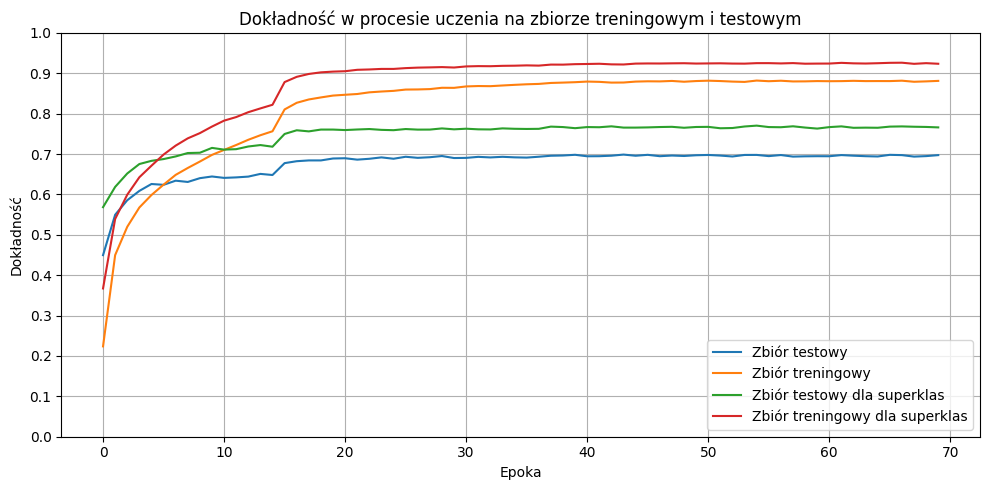

In [69]:
plt.figure(figsize=(10,5))
plt.title("Dokładność w procesie uczenia na zbiorze treningowym i testowym")
plt.plot(test_acc[:71],label="Zbiór testowy")
plt.plot(train_acc[:71],label="Zbiór treningowy")
plt.plot(test_acc_super[:71],label="Zbiór testowy dla superklas")
plt.plot(train_acc_super[:71],label="Zbiór treningowy dla superklas")
plt.xlabel("Epoka")
plt.ylabel("Dokładność")
plt.xticks(np.arange(0,71,10))
plt.yticks(np.arange(0.0,1.1,0.1))
plt.grid()
plt.legend()
plt.savefig('tiny_doublecriterion80.png')
plt.tight_layout()
plt.show()

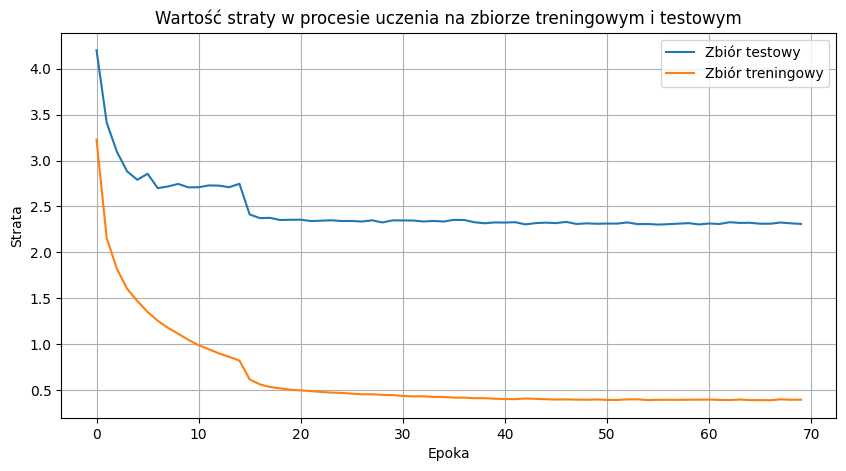

In [71]:
plt.figure(figsize=(10,5))
plt.title("Wartość straty w procesie uczenia na zbiorze treningowym i testowym")
plt.plot(test_loss[:71],label="Zbiór testowy")
plt.plot(train_loss[:71],label="Zbiór treningowy")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.xticks(np.arange(0,71,10))
plt.grid()
plt.legend()
plt.savefig('tiny_loss_calkowite80.png')
plt.show()

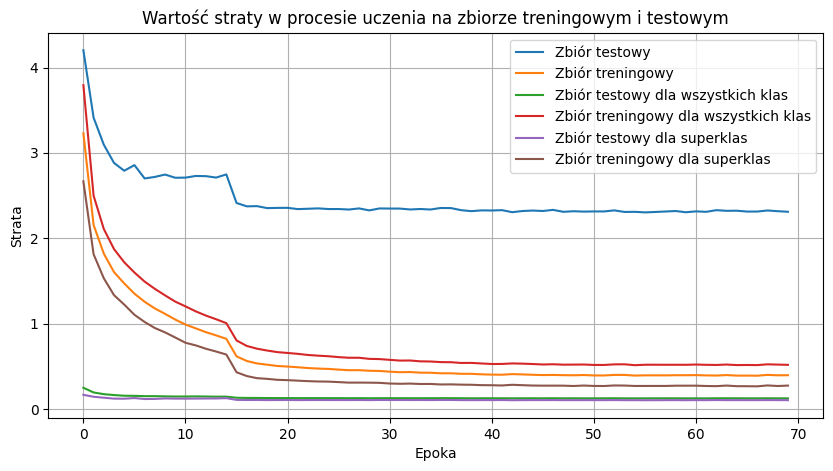

In [72]:
plt.figure(figsize=(10,5))
plt.title("Wartość straty w procesie uczenia na zbiorze treningowym i testowym")
plt.plot(test_loss[:71],label="Zbiór testowy")
plt.plot(train_loss[:71],label="Zbiór treningowy")
plt.plot(test_loss_class[:71],label="Zbiór testowy dla wszystkich klas")
plt.plot(train_loss_class[:71],label="Zbiór treningowy dla wszystkich klas")
plt.plot(test_loss_superclass[:71],label="Zbiór testowy dla superklas")
plt.plot(train_loss_superclass[:71],label="Zbiór treningowy dla superklas")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.xticks(np.arange(0,71,10))
plt.grid()
plt.legend()
plt.savefig('tiny_loss_wszystkie80.png')
plt.show()

# Look inside a dictionary

In [ ]:
checkpoint = torch.load("___.pth")

In [ ]:
checkpoint['test_accuracy']

# Separate saving .pth file

In [ ]:
model_save_path = '/kaggle/working/____' + str(87) + '.pth'
training_stats = {
    'epoch': epoch+1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'loss': average_loss,
    'loss_class': average_loss_class,
    'loss_superclass':average_loss_superclass,
    'accuracy': accuracy,
    'accuracy_super': accuracy_super,
    'test_accuracy': accuracy_test,
    'test_accuracy_super':accuracy_test_super,
    'test_loss': average_loss_test,
    'test_loss_class':average_loss_class_test,
    'test_loss_superclass':average_loss_superclass_test,
    'learning_rate': optimizer.param_groups[0]["lr"]
}

In [ ]:
torch.save(training_stats, model_save_path)

# Transfering the weights into a new model

Aiming to fine-tune only the classification layer

## Model setup

In [ ]:
saved_model_path = '/kaggle/input/tinymodel52/resnet_tiny_200classes_e25.pth'

In [ ]:
model_test=resnet18(weights=None)
model_test.conv1=nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False)
model_test.maxpool=nn.Identity()
num_in_ftrs=model_test.fc.in_features
num_out_ftrs=model_test.fc.out_features
num_classes=200
model_test.fc=nn.Linear(num_in_ftrs,num_classes)

## Model weights loading

In [ ]:
checkpoint = torch.load(saved_model_path)
model_test.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
for param in model_test.parameters():
    param.requires_grad = False
for param in model_test.fc.parameters():
    param.requires_grad = True

In [ ]:
print([param.requires_grad for param in model_test.parameters()])

In [ ]:
num_classes=200
model_test.fc =nn.Linear(num_in_ftrs, num_classes)

In [ ]:
model_test.to(device)

In [ ]:
model_test.eval().to(device)

In [ ]:
correct_test, total_test= 0, 0
with torch.no_grad():
    for (inputs, targets) in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_test(inputs)
        __, predicted = outputs.max(1)
        correct_test += predicted.eq(targets).sum().item()
        total_test+= targets.size(0)

accuracy_test = correct_test / total_test
accuracy_test_prc=accuracy_test*100
print(f'Accuracy on test data: {accuracy_test_prc:.2f} %')

# Retraining the net

In [ ]:
ep=10
for e in range(ep):
    correct_test, total_test= 0, 0
    with torch.no_grad():
        for (inputs, targets) in test_dl:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_test(inputs)
            __, predicted = outputs.max(1)
            correct_test += predicted.eq(targets).sum().item()
            total_test+= targets.size(0)

    accuracy_test = correct_test / total_test
    accuracy_test_prc=accuracy_test*100
    print(f'Accuracy on test data: {accuracy_test_prc:.2f} %')

In [ ]:
model_save_path = '/kaggle/working/resnet_cifar100_transferlearningfor100clasep14' + str(epoch+1) + '.pth'

In [ ]:
training_stats = {
  'epoch': epoch+1,
  'model_state_dict': model_test.state_dict(),
  'optimizer_state_dict': optimizer.state_dict(),
  'scheduler_state_dict': scheduler.state_dict(),
  'loss': average_loss,
  'accuracy': accuracy,
  'test_accuracy': accuracy_test,
  'test_loss': average_loss_test,
  'learning_rate': optimizer.param_groups[0]["lr"]
}

In [ ]:
torch.save(training_stats, model_save_path)

# Test the model, confusion matrix

In [ ]:
model_test.eval()
correct_test, total_test= 0, 0
all_preds = []
all_labels = []
with torch.no_grad():
    for (inputs, targets) in val_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_test(inputs)
        __, predicted = outputs.max(1)
        correct_test += predicted.eq(targets).sum().item()
        total_test+= targets.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

accuracy_test = correct_test / total_test
accuracy_test_prc=accuracy_test*100
print(f'Accuracy on test data: {accuracy_test_prc:.2f} %')

In [ ]:
true_class_names  = [classes_indexing_inverted[label] for label in all_labels]
pred_class_names  = [classes_indexing_inverted[label] for label in all_preds]

In [ ]:
true_superclasses = [filt_class_map[label] for label in true_class_names ]
pred_superclasses = [filt_class_map[label] for label in pred_class_names ]

In [ ]:
true_superclasses=[coarse_classes_indexing[label] for label in true_superclasses]
pred_superclasses=[coarse_classes_indexing[label] for label in pred_superclasses]

In [ ]:
df=metrics_class(true_superclasses,pred_superclasses,make_df=True)

In [ ]:
df_c=pd.read_csv('/kaggle/working/tiny_imagenet_200AFTER_class_metrics_per_class.csv')

In [ ]:
df.to_csv('tiny_imagenet_200_class_metrics_per_class.csv')

In [ ]:
def metrics_class(label,pred,output=False, make_df=False,save_df=False, model_name=None):
    
    conf_matrix = confusion_matrix(label, pred, labels=np.arange(52))
    class_acc=conf_matrix.diagonal()/conf_matrix.sum(1)
    FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  # False Positives for each class
    FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)  # False Negatives for each class
    TP = np.diag(conf_matrix)  # True Positives for each class
    TN = conf_matrix.sum() - (FP + FN + TP)  # True Negatives for each class

    FPR = FP / (FP + TN)  # False Positive Rate
    FNR = FN / (TP + FN)  # False Negative Rate
    specificity = TN / (TN + FP)  # Specificity
    sensitivity= TP/(TP+FN)
    precision=TP/(TP+FP)
    f1_score_=(2*precision*sensitivity)/(precision+sensitivity)
    
    if output:
        for idx, (fp_rate, fn_rate, spec, sens, prec, acc, f1) in enumerate(zip(FPR, FNR, specificity, sensitivity, precision, class_acc, f1_score_)):
            print(f"Class {idx} - FPR: {fp_rate}, FNR: {fn_rate}, TNR: {spec}, TPR: {sens}, Precision: {prec}, Accuracy: {acc}, F1-score: {f1}")
    
    df_metrics={
        'Dokładność na klasę (ang. \textit{Accuracy per class})': class_acc,
        'Czułość (ang. \textit{Recall})': sensitivity,
        'Precyzja (ang.\textit{Precision})': precision,
        'Specyficzność (ang. Specificity)': specificity,
        'F1-score': f1_score_,
        'FPR':FPR,
        'FNR':FNR
    }
    
    if make_df:
        df_metrics=pd.DataFrame(df_metrics)
        if save_df:
            save_path=model_name+'_class_metrics.csv'
            df_metrics.to_csv(save_path)
    
    return df_metrics

In [ ]:
confusion = defaultdict(Counter)
for true_class, pred_class in zip(all_labels, all_preds):
    true_class_name = classes_indexing_inverted[true_class]
    pred_class_name = classes_indexing_inverted[pred_class]
    true_superclass = filt_class_map[true_class_name]
    pred_superclass = filt_class_map[pred_class_name]
    if true_superclass != pred_superclass:
        confusion[true_superclass][pred_class] += 1

In [ ]:
df.to_csv('tiny_imagenet_pomyłki_200.csv')

In [ ]:
data = []

for superclass_name, (class_index, num_errors) in most_common_errors.items():
    superclass_index = coarse_classes_indexing[superclass_name]
    class_id = classes_indexing_inverted[class_index]
    class_name=class_id_to_name[class_id]
    data.append([superclass_index, superclass_name, class_index, class_name])

# Tworzenie dataframe
df = pd.DataFrame(data, columns=['nr_superklasy', 'nazwa_superklasy', 'nr_klasy', 'nazwa_klasy'])

print(df)

In [ ]:
most_common_errors = {}
for superclass, errors in confusion.items():
    most_common_error = errors.most_common(1)[0]  # Najczęstsza pomyłka
    most_common_errors[superclass] = most_common_error

print(most_common_errors)

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

In [ ]:
plt.figure(figsize=(25, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linecolor='black', linewidth=0.5)
plt.xlabel('Klasa przewidywana')
plt.ylabel('Klasa rzeczywista ')
plt.title('Macierz pomyłek')
plt.savefig('CM_tiny_52.png')
plt.show()

In [ ]:
for i in all_labels:
    label_name=

# Plots

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Dokładność w procesie uczenia na zbiorze treningowym i testowym")
plt.plot(test_acc[:61],label="Zbiór testowy")
plt.plot(train_acc[:61],label="Zbiór treningowy")
plt.xlabel("Epoka")
plt.ylabel("Dokładność")
plt.xticks(np.arange(0,61,5))
plt.grid()
plt.legend()
plt.savefig('tiny_accuracy_model19.png')
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Wartość straty w procesie uczenia na zbiorze treningowym i testowym")
plt.plot(test_loss[:61],label="Zbiór testowy")
plt.plot(train_loss[:61],label="Zbiór treningowy")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.xticks(np.arange(0,61,5))
plt.grid()
plt.legend()
plt.savefig('tiny_loss_odel19.png')
plt.show()